In [1]:
import numpy as np
import random
import math
from scipy.stats import beta
import networkx as nx
import pandas as pd
from matplotlib import animation
from IPython.display import HTML, display

from mesa import Model, Agent
from mesa.space import NetworkGrid
from mesa.time import RandomActivation

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import mpmath 
from mpmath import mp
mp.prec = 100
sns.set()
from tqdm.notebook import tqdm
from itertools import starmap
from multiprocess import Pool, cpu_count


ModuleNotFoundError: No module named 'multiprocess'

In [2]:

class SimpleAction(object):
    
    def __init__(self, prob_success):
        
        assert prob_success >= 0 and prob_success <= 1, f"{prob_success} must be between 0 and 1"
        self.prob_success = prob_success
        
    def execute(self, num = 1): 
        
        return np.random.binomial(num, self.prob_success) 
        
    def pr(self, num_success, total):
        
        assert num_success <= total, f"the successes {num_success} cannot be greater than the total {total}"
        return mp.mpf(self.prob_success)**mp.mpf(num_success) * mp.mpf((1 - self.prob_success))**mp.mpf((total - num_success))

    def __str__(self):
        return f"P(s)={self.prob_success}"


In [3]:
class Learner(Agent):
    
    def __init__(self, unique_id, model, known_mean, acts, pos, default_num_trials = 1000):
        super().__init__(unique_id, model)
        self.known_mean = known_mean
        self.default_num_trials = default_num_trials
        self.acts = acts
        
        self.num_success = 0 # number of successes of the current experiment
        self.num_trials = 0 # number of times the current experiment was performed
        if len(acts) == 2:
            prior = generate_prior_two_acts()
            self.pr = {acts[0]: prior[0], acts[1]: prior[1]} 
        else:
            prior = generate_prior(len(acts))
            self.pr = {a: prior[a_idx] for a_idx,a in enumerate(acts)}
        self.pos = pos
        
    def belief(self, act):
        return self.pr[act]
                
    def update_bayes(self, num_success, num_trials): 
        '''update using Bayes Theorem'''
        new_bel = dict()
        for act in self.pr.keys():
            new_bel[act] = act.pr(num_success, num_trials) * self.pr[act] / sum((self.pr[_a] * _a.pr(num_success, num_trials) for _a in self.acts))
        self.pr = new_bel
                
    def choice(self):
        act = max(self.pr.items(), key = lambda p: p[1])[0]  
        if act.prob_success > self.known_mean:
            return act
        else: 
            return None
    
    def experiment(self, num_trials = None): 
                
        act = self.choice()

        if act is not None:
            num_trials = num_trials if num_trials is not None else self.default_num_trials
            self.num_success = act.execute(num=num_trials)
            self.num_trials = num_trials
        else: 
            self.num_success = 0
            self.num_trials = 0
    
class BGModel(Model):
    
    def __init__(self, network, acts, true_act, known_mean, 
                 default_num_trials = 1000):
                
        self.acts = acts
        self.true_act = true_act 
        self.known_mean = known_mean
        self.schedule = RandomActivation(self)
        self.network = NetworkGrid(network)
        self.running = True
        
        
        # Set up the agents
        agent_id = 0
        for n in network.nodes:
            agent = Learner(agent_id, 
                            self, 
                            self.known_mean, 
                            self.acts, 
                            n, # position in network
                            default_num_trials = default_num_trials)
            self.network.place_agent(agent, n)
            self.schedule.add(agent)
            agent_id += 1
        
    def converged(self): 
        
        if all([a.belief(self.true_act) > mp.mpf(0.99) for a in self.schedule.agents]): 
            return 1 # beliefs converged on the true act
        elif all([a.choice() is None for a in self.schedule.agents]): 
            return 0 # no longer experimenting
        else: 
            return -1 # undecided
            
    def step(self, num_tests = None):
        
        # all the agents perform their experiments
        for a in self.schedule.agents:
            a.experiment(num_tests)
        
        for a in self.schedule.agents:
            
            total_success = 0
            total_trials = 0
            # neighbors include a
            neighbors_nodes = [n_pos for n_pos in self.network.get_neighbors(a.pos, include_center = True)]
            neighbors = [n for n in self.schedule.agents if n.pos in neighbors_nodes]
            for n in neighbors: 
                total_success += n.num_success
                total_trials += n.num_trials
            a.update_bayes(total_success, total_trials)
                            
        if self.converged() in [0,1]:
            self.running = False


In [4]:
def generate_prior_two_acts(): 
    pr1 = np.random.uniform(0,1)
    return pr1, 1-pr1

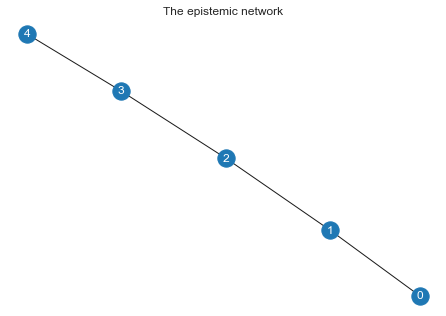

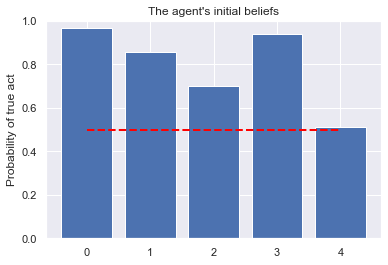

After 23 experiment(s), the convergence type is  Successful



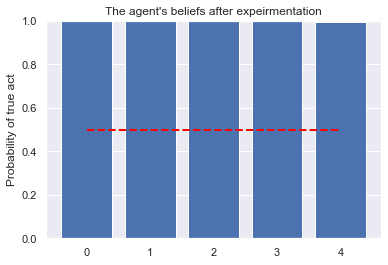

In [5]:

known_mean = 0.5
num_trials = 100 # the number of trials performed by the agents at each round
num_experts = 5 # number of experts
G = nx.path_graph(num_experts) # the epsitemic network

epsilon = 0.01
true_act = SimpleAction(known_mean + epsilon)
acts = [true_act, SimpleAction(known_mean - epsilon)]

max_num_experiments = 1000

convergence_types = {
    1: "Successful",
    0: "Unsuccessful",
    -1: "Undecided"
}

nx.draw(G, with_labels=True, font_color='white')
plt.title("The epistemic network")
plt.show()

plt.cla()

model = BGModel(G, acts, true_act, known_mean, default_num_trials = num_trials)

plt.bar([str(a.unique_id) for a in model.schedule.agents], 
        [a.belief(true_act) for a in model.schedule.agents])    
plt.plot([str(a.unique_id) for a in model.schedule.agents], 
         [known_mean]*len(model.schedule.agents), 
         '--', color='red',lw=2)     
plt.title("The agent's initial beliefs")
plt.ylim(0,1)
plt.ylabel("Probability of true act")
plt.show()
plt.cla()

num_experiments = 0
while model.running and num_experiments < max_num_experiments:
    model.step()
    num_experiments += 1
    
print(f"After {num_experiments} experiment(s), the convergence type is  {convergence_types[model.converged()]}")
print()

plt.bar([str(a.unique_id) for a in model.schedule.agents], 
        [a.belief(true_act) for a in model.schedule.agents])     
plt.plot([str(a.unique_id) for a in model.schedule.agents], 
         [known_mean]*len(model.schedule.agents), 
         '--', color='red', lw=2)      
plt.title("The agent's beliefs after expeirmentation")
plt.ylim(0,1)
plt.ylabel("Probability of true act")
plt.ylim(0,1)
plt.show()


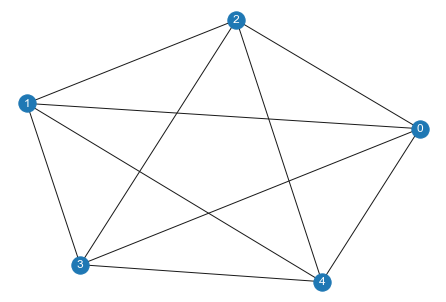

<Figure size 432x288 with 0 Axes>

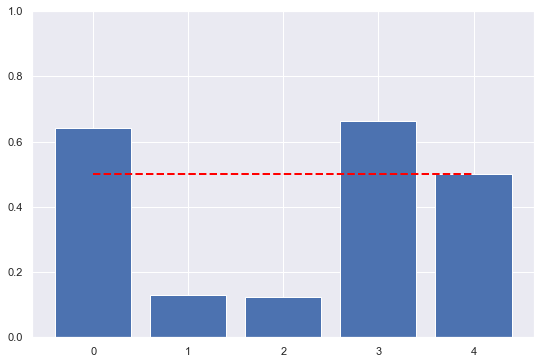

In [6]:
known_mean = 0.5
epsilon = 0.01
true_act = SimpleAction(known_mean + epsilon)
acts = [true_act, SimpleAction(known_mean - epsilon)]

num_agents = 5
G=nx.complete_graph(num_agents)

default_num_trials = 10

nx.draw(G, with_labels=True, font_color='white')
plt.show();
plt.clf()
fig, ax = plt.subplots(figsize=(9,6));
m = 2

model = BGModel(G, acts, true_act, known_mean, default_num_trials = default_num_trials)

ax.bar([str(a.unique_id) for a in model.schedule.agents], 
       [a.belief(true_act) for a in model.schedule.agents])  

ax.plot([str(a.unique_id) for a in model.schedule.agents], 
        [known_mean]*len(model.schedule.agents), 
        '--', color='red',lw=2)
ax.set_ylim(0,1)
plt.show();

def draw_barchart(num):
    model.step()
    ax.clear()
    ax.bar([str(a.unique_id) for a in model.schedule.agents],
           [a.belief(true_act) for a in model.schedule.agents])   
    ax.plot([str(a.unique_id) for a in model.schedule.agents], 
            [known_mean]*len(model.schedule.agents), '--', color='red',lw=2)     
    ax.set_ylim(0,1)
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 100), interval=1)
HTML(animator.to_jshtml())


In [7]:
from multiprocess import Pool, cpu_count

def run_simulation(network, m, acts, true_act, known_mean, max_num_experiments):
    
    data = {
        "successful_convergence": 0,
        "time_to_convergence": 0,
        "unsuccessful_convergence": 0,
    }
    
    model = BGModel(network, m, acts, true_act, known_mean)
    num_experiments = 0
    while model.running and num_experiments < max_num_experiments:
        model.step()
        num_experiments += 1
        
    convergence_type = model.converged()
    
    if convergence_type == 1:
        data["successful_convergence"] = 1
        data["time_to_convergence"] = num_experiments
    elif convergence_type == 0:
        data["unsuccessful_convergence"] = 1
        data["time_to_convergence"] = num_experiments
    return data



ModuleNotFoundError: No module named 'multiprocess'

In [8]:

SKIP_SIMULATION = True # skip running this by default, since it takes a very long time to run

if not SKIP_SIMULATION: 
    all_prob_data = {
        "num_agents": list(),
        "graph": list(),
        "difficulty": list(),
        "prob_successful_convergence": list(),
        "prob_unsuccessful_convergence": list(),
        "avg_time_to_convergence": list(),  
    }

    all_data = {
        "num_agents": list(),
        "graph": list(),
        "difficulty": list(),
        "successful_convergence": list(),
        "unsuccessful_convergence": list(),
        "time_to_convergence": list(),  
    }

    all_num_agents = [3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20]

    graphs = {
        "path": {n: nx.path_graph(n) for n in all_num_agents},
        "wheel": {n: nx.wheel_graph(n) for n in all_num_agents},
        "complete": {n: nx.complete_graph(n) for n in all_num_agents},
        "cycle": {n: nx.cycle_graph(n) for n in all_num_agents},
    }

    epsilons = [0.1, 0.01, 0.001]#, 0.01, 0.001]

    num_simulations = 10000

    m = None
    known_mean = 0.5
    max_num_experiments = 1200

    for num_agents in tqdm(all_num_agents):
        for epsilon in epsilons:
            for graph_type in graphs.keys():
                true_act = SimpleAction(known_mean + epsilon)
                acts = [true_act, SimpleAction(known_mean - epsilon)]
                m = None

                G = graphs[graph_type][num_agents]
                output = pool.starmap(run_simulation, 
                                      [(G, m, acts, true_act, known_mean, max_num_experiments)]* num_simulations)

                successful_convergence = 0
                unsuccessful_convergence = 0
                for o in output: 
                    all_data["num_agents"].append(num_agents)
                    all_data["graph"].append(graph_type)
                    all_data["difficulty"].append(epsilon)
                    all_data["successful_convergence"].append(o["successful_convergence"])
                    all_data["unsuccessful_convergence"].append(o["unsuccessful_convergence"])
                    all_data["time_to_convergence"].append(o["time_to_convergence"])
                    successful_convergence += o["successful_convergence"]
                    unsuccessful_convergence += o["unsuccessful_convergence"]
                all_prob_data["num_agents"].append(num_agents)
                all_prob_data["graph"].append(graph_type)
                all_prob_data["difficulty"].append(epsilon)
                all_prob_data["prob_successful_convergence"].append(float(successful_convergence) / float(num_simulations))
                all_prob_data["prob_unsuccessful_convergence"].append(float(unsuccessful_convergence) / float(num_simulations))
                all_prob_data["avg_time_to_convergence"].append(np.average(all_data["time_to_convergence"]))
        df_all_prob = pd.DataFrame(all_prob_data)
        df_all = pd.DataFrame(all_data)
        df_all.to_csv("all_data.csv",index=False)
        df_all_prob.to_csv("all_prob_data.csv",index=False)


In [9]:
df_all_prob = pd.read_csv(open("from_aws/all_prob_data.csv", "rb"))

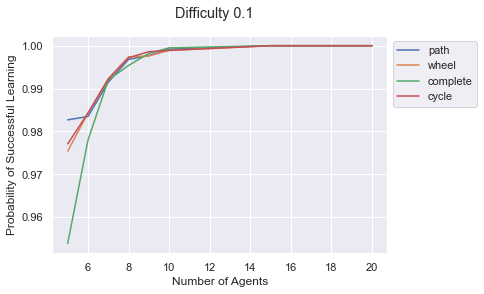

In [10]:
difficulty = 0.1

ax= sns.lineplot(x="num_agents", 
                 y="prob_successful_convergence",
                 hue='graph', 
                 data = df_all_prob[df_all_prob['difficulty'] == difficulty])
ax.set_ylabel("Probability of Successful Learning")
ax.set_xlabel("Number of Agents")
plt.legend(bbox_to_anchor=(1,1))
plt.suptitle(f"Difficulty {difficulty}")
plt.show();

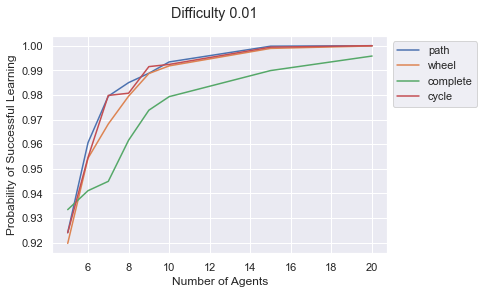

In [11]:
difficulty = 0.01

ax= sns.lineplot(x="num_agents", 
                 y="prob_successful_convergence",
                 hue='graph', 
                 data = df_all_prob[df_all_prob['difficulty'] == difficulty])
ax.set_ylabel("Probability of Successful Learning")
ax.set_xlabel("Number of Agents")
plt.legend(bbox_to_anchor=(1,1))
plt.suptitle(f"Difficulty {difficulty}")
plt.show();

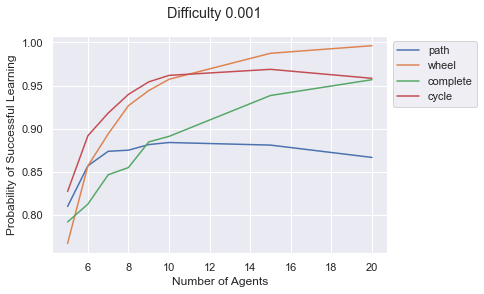

In [12]:
difficulty = 0.001

ax= sns.lineplot(x="num_agents", 
                 y="prob_successful_convergence",
                 hue='graph', 
                 data = df_all_prob[df_all_prob['difficulty'] == difficulty])
ax.set_ylabel("Probability of Successful Learning")
ax.set_xlabel("Number of Agents")
plt.legend(bbox_to_anchor=(1,1))
plt.suptitle(f"Difficulty {difficulty}")
plt.show();

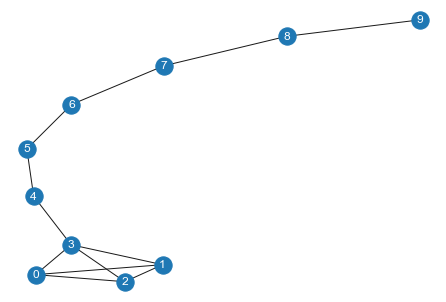

In [13]:

G = nx.lollipop_graph(4, 6)

nx.draw(G, with_labels=True, font_color='white')
plt.show();


In [14]:

SKIP_SIMULATION = True # skip running this by default, since it takes a very long time to run

if not SKIP_SIMULATION: 
    print(f'CPUS: {cpu_count()}')
    cpus = cpu_count()
    pool = Pool(12)

    all_prob_data = {
        "num_agents": list(),
        "graph": list(),
        "difficulty": list(),
        "prob_successful_convergence": list(),
        "prob_unsuccessful_convergence": list(),
        "avg_time_to_convergence": list(),  
    }

    all_data = {
        "num_agents": list(),
        "graph": list(),
        "difficulty": list(),
        "successful_convergence": list(),
        "unsuccessful_convergence": list(),
        "time_to_convergence": list(),  
    }


    graphs = {
        "complete": nx.lollipop_graph(10,0),
        "complete-1": nx.lollipop_graph(9,1),
        "complete-2": nx.lollipop_graph(8,2),
        "complete-3": nx.lollipop_graph(7,3),
        "complete-4": nx.lollipop_graph(6,4),
        "complete-5": nx.lollipop_graph(5,5),
        "complete-6": nx.lollipop_graph(4,6),
        "complete-7": nx.lollipop_graph(3,7),
        "path": nx.lollipop_graph(2,8),
    }


    m = None
    known_mean = 0.5
    max_num_experiments = 1500

    num_simulations = 10#000

    num_agents = 10
    epsilon = 0.001

    true_act = SimpleAction(known_mean + epsilon)
    acts = [true_act, SimpleAction(known_mean - epsilon)]

    for graph_type in tqdm(graphs.keys()):

        G = graphs[graph_type]
        output = pool.starmap(run_simulation, 
                              [(G, m, acts, true_act, known_mean, max_num_experiments)]* num_simulations)

        successful_convergence = 0
        unsuccessful_convergence = 0
        for o in output: 
            all_data["num_agents"].append(num_agents)
            all_data["graph"].append(graph_type)
            all_data["difficulty"].append(epsilon)
            all_data["successful_convergence"].append(o["successful_convergence"])
            all_data["unsuccessful_convergence"].append(o["unsuccessful_convergence"])
            all_data["time_to_convergence"].append(o["time_to_convergence"])
            successful_convergence += o["successful_convergence"]
            unsuccessful_convergence += o["unsuccessful_convergence"]
        all_prob_data["num_agents"].append(num_agents)
        all_prob_data["graph"].append(graph_type)
        all_prob_data["difficulty"].append(epsilon)
        all_prob_data["prob_successful_convergence"].append(float(successful_convergence) / float(num_simulations))
        all_prob_data["prob_unsuccessful_convergence"].append(float(unsuccessful_convergence) / float(num_simulations))
        all_prob_data["avg_time_to_convergence"].append(np.average(all_data["time_to_convergence"]))

    df_all_prob = pd.DataFrame(all_prob_data)
    df_all = pd.DataFrame(all_data)
    df_all.to_csv("diff_graphs_all_data.csv",index=False)
    df_all_prob.to_csv("diff_graphs_all_prob_data.csv",index=False)


In [15]:
diff_graphs_df_all_prob = pd.read_csv(open("from_aws/diff_graphs_all_prob_data.csv", "rb"))

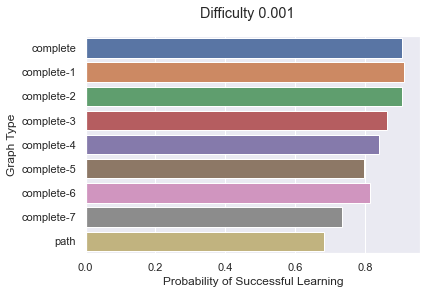

In [16]:
difficulty = 0.001

ax = sns.barplot(y="graph", 
                 x="prob_successful_convergence",
                 data = diff_graphs_df_all_prob[diff_graphs_df_all_prob['difficulty'] == difficulty],
               orient='h')
ax.set_ylabel("Graph Type")
ax.set_xlabel("Probability of Successful Learning")
#plt.legend(bbox_to_anchor=(1,1))
plt.suptitle(f"Difficulty {difficulty}")
plt.show();